In [13]:
import sys
from pathlib import Path

# add src/ to path
PROJECT_ROOT = Path("..").resolve()
SRC_PATH = PROJECT_ROOT / "src"
sys.path.append(str(SRC_PATH))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
from cycle_tda.io import load_csv
from cycle_tda.transforms import log_price, log_returns
from cycle_tda.experiments import run_cycle_ph_experiment


In [15]:
df_xau = load_csv(
    PROJECT_ROOT / "data/raw/XAU_Monthly.csv",
    date_col="Date",
    value_col="Close"
)

df_xau = df_xau.set_index("Date")
df_xau.head()


,Close
Date,
1793-03-31,19.39
1793-06-30,19.39
1793-09-30,19.39
1793-12-31,19.39
1794-03-31,19.39


In [16]:
CYCLE_YEARS = 8.88
WINDOW_MONTHS = int(round(CYCLE_YEARS * 12))

m = 12
tau = 3

WINDOW_MONTHS, m, tau


(107, 12, 3)

In [17]:
df_roll = run_cycle_ph_experiment(
    series=df_xau["Close"],
    cycle_months=WINDOW_MONTHS,
    m=m,
    tau=tau,
)

df_roll.head()


,date,cycle_strength,window,m,tau,representation
0,1819-12-31,0.035242,107,12,3,log_price
1,1820-03-31,0.035242,107,12,3,log_price
2,1820-06-30,0.035242,107,12,3,log_price
3,1820-09-30,0.035242,107,12,3,log_price
4,1820-12-31,0.035242,107,12,3,log_price


In [18]:
df_price = df_roll[df_roll["representation"] == "log_price"].copy()
df_ret   = df_roll[df_roll["representation"] == "log_returns"].copy()

df_price.shape, df_ret.shape


((1289, 6), (1288, 6))

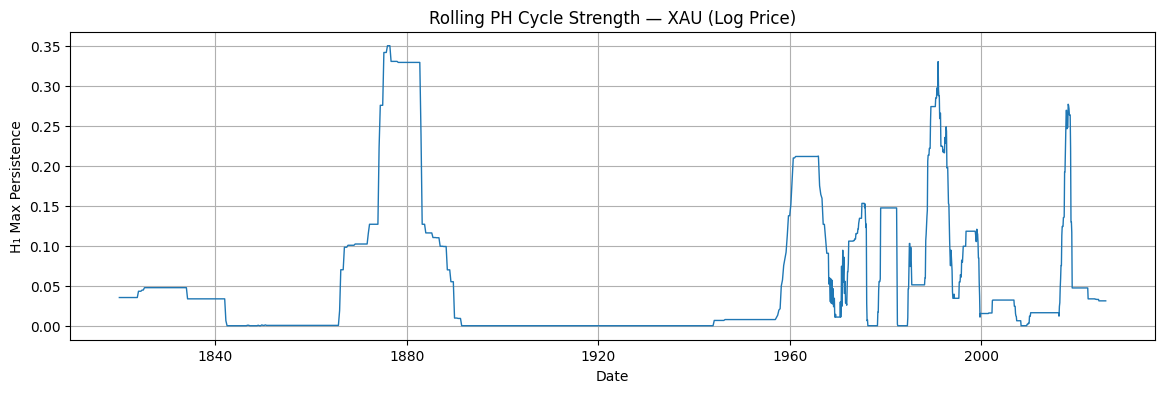

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(df_price["date"], df_price["cycle_strength"], linewidth=1)

plt.title("Rolling PH Cycle Strength — XAU (Log Price)")
plt.xlabel("Date")
plt.ylabel("H₁ Max Persistence")
plt.grid(True)
plt.show()


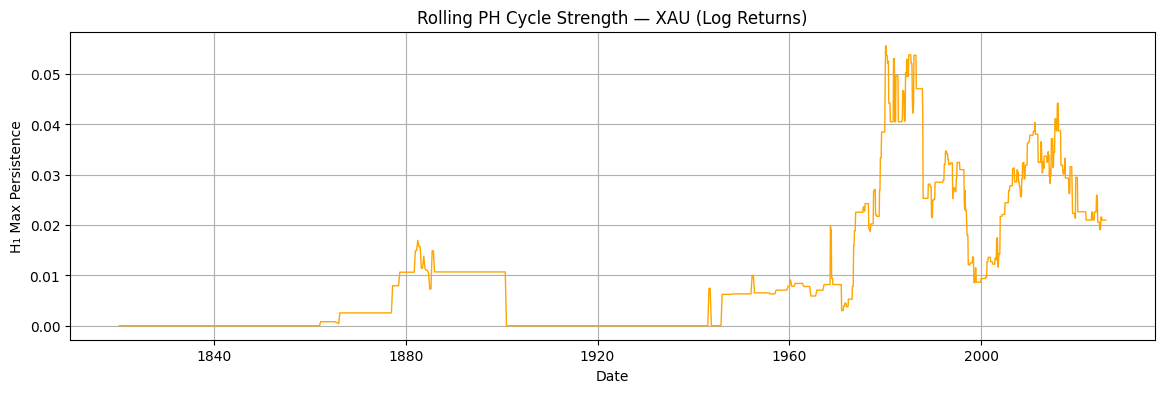

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(
    df_ret["date"],
    df_ret["cycle_strength"],
    linewidth=1,
    color="orange"
)

plt.title("Rolling PH Cycle Strength — XAU (Log Returns)")
plt.xlabel("Date")
plt.ylabel("H₁ Max Persistence")
plt.grid(True)
plt.show()


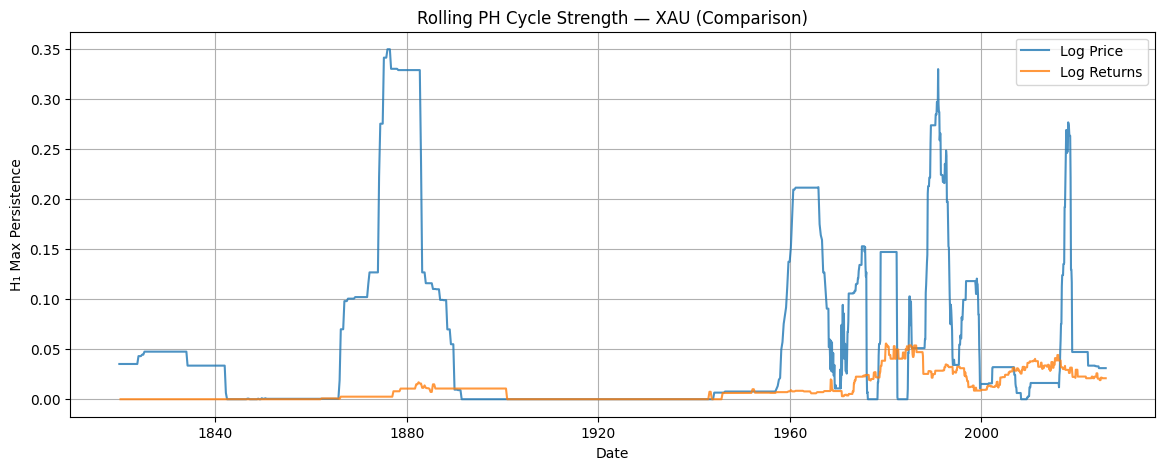

In [21]:
plt.figure(figsize=(14, 5))

plt.plot(
    df_price["date"],
    df_price["cycle_strength"],
    label="Log Price",
    alpha=0.8
)

plt.plot(
    df_ret["date"],
    df_ret["cycle_strength"],
    label="Log Returns",
    alpha=0.8
)

plt.title("Rolling PH Cycle Strength — XAU (Comparison)")
plt.xlabel("Date")
plt.ylabel("H₁ Max Persistence")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
summary = (
    df_roll
    .groupby("representation")["cycle_strength"]
    .describe()
)

summary


,count,mean,std,min,25%,50%,75%,max
representation,,,,,,,,
log_price,1289.0,0.060456,0.080839,0.0,4.114078e-04,0.032075,0.099351,0.350002
log_returns,1288.0,0.015854,0.015110,0.0,6.984919e-10,0.010692,0.027802,0.055641


In [23]:
def top_regimes(df, q=0.95):
    thresh = df["cycle_strength"].quantile(q)
    return df[df["cycle_strength"] >= thresh]

top_price = top_regimes(df_price)
top_ret   = top_regimes(df_ret)

top_price.head(), top_ret.head()


(          date  cycle_strength  window   m  tau representation
 218 1874-06-30        0.275527     107  12    3      log_price
 219 1874-09-30        0.275527     107  12    3      log_price
 220 1874-12-31        0.275527     107  12    3      log_price
 221 1875-03-31        0.341570     107  12    3      log_price
 222 1875-06-30        0.341570     107  12    3      log_price,
            date  cycle_strength  window   m  tau representation
 2024 1979-12-31        0.048672     107  12    3    log_returns
 2025 1980-01-31        0.055641     107  12    3    log_returns
 2026 1980-02-29        0.055641     107  12    3    log_returns
 2027 1980-03-31        0.053724     107  12    3    log_returns
 2028 1980-04-30        0.053724     107  12    3    log_returns)

In [24]:
# ===============================
# Define Cyclic Regime
# ===============================

# Use log-price representation only
df_price = df_roll[df_roll["representation"] == "log_price"].copy()

# Define threshold (research choice, not optimization)
CYCLIC_QUANTILE = 0.95
threshold = df_price["cycle_strength"].quantile(CYCLIC_QUANTILE)

df_price["cyclic_regime"] = np.where(
    df_price["cycle_strength"] >= threshold,
    "Cyclic",
    "Non-Cyclic"
)

threshold


np.float64(0.2634727358818054)

In [25]:
# Merge cyclic regime back into df_roll
df_roll = df_roll.merge(
    df_price[["date", "cyclic_regime"]],
    on="date",
    how="left"
)

df_roll["cyclic_regime"].value_counts(dropna=False)


cyclic_regime
Non-Cyclic    2445
Cyclic         132
Name: count, dtype: int64

In [26]:
pd.crosstab(
    df_roll["representation"],
    df_roll["cyclic_regime"]
)

cyclic_regime,Cyclic,Non-Cyclic
representation,,
log_price,66,1223
log_returns,66,1222


In [27]:
# ===============================
# Export for downstream analysis
# ===============================

export_path = PROJECT_ROOT / "powerbi/exports/PH_XAU_8p88y_Rolling.csv"

df_roll.reset_index(drop=True).to_csv(export_path, index=False)

export_path


PosixPath('/Users/Rod/Desktop/cycle-tda-lab/powerbi/exports/PH_XAU_8p88y_Rolling.csv')